<h1><a href="#top">MNIST GUAI model prep</a></h1>

<ul>
    <li><a href='#part0'>Training a binary classifier</a></li>
    <li><a href='#part1'>Implementing cross validation</a></li>
    <li><a href='#part2'>Confusion Matrix</a></li>
    <li><a href='#part3'>Roc/AUC</a></li>
    <li><a href='#part4'>Multiclass classification</a></li>
    <li><a href='#part5'>Error Analysis</a></li>
    <li><a href='#part6'>Multilabel classification</a></li>
    <li><a href='#part7'>Multioutput classification</a></li>
    <li><a href='#part8'>Final Model</a></li>
</ul>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']
#Cast labels from string to int
y = y.astype(np.uint8)
#train_test_split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

There are 70000 images and 784 features because each image out of the 70000 is flattened from 28px by 28px

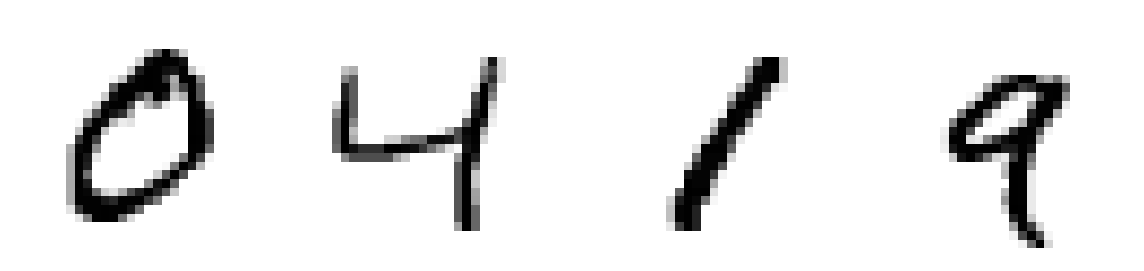

In [2]:
plt.figure(figsize=(10,10))
for x in range(1,5):
    plt.subplot(1,4,x)
    digit = X[x]
    digit_to_image = digit.reshape(28,28)
    plt.imshow(digit_to_image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

<a id='part0'></a>
### Training a binary cassifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([X[0]])

array([ True])

<a id='part1'></a>
### Implementing cross-validation

In [11]:
# This piece of code does the same job as cross_val_score() from sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

/home/zowlex/ml/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [12]:
#Now using cross_val_score
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Not5(BaseEstimator):
    def fit(self, X,y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
not_5_clf = Not5()
cross_val_score(not_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Class of number 5 represents 10% of the dataset so our not_5 classifier is going to be 90% of the time accurate, that's why accuracy is not a good performance measure in the case of **skewed datasets (when some classes are more frequent than others)**

<a id='part2'></a>
### Confusion Matrix

In [105]:
from sklearn.model_selection import cross_val_predict

#y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

In [16]:
#in a perfect world
y_train_perfect_preds = y_train_5
confusion_matrix(y_train_5, y_train_perfect_preds)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [17]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
print('precision_score:',TP/(TP+FP))
print('recall_score:',TP/(TP+FN))

precision_score: 0.8370879772350012
recall_score: 0.6511713705958311


In [18]:
from sklearn.metrics import precision_score, recall_score
print('precision_score:',precision_score(y_train_5, y_train_pred))
print('recall_score:',recall_score(y_train_5, y_train_pred))

precision_score: 0.8370879772350012
recall_score: 0.6511713705958311


- Precision: 83.7 % predictions are correct
- Recall: 65.1 % detected 5's 

### F1 score
F1 score is the harmony of precision and recall and it is between 0 and 1, achieving its highest score only if both precision and recall are high

$$F1 = 2* \frac{Precision * Recall}{Precision+Recall}$$

In [19]:
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

In [20]:
threshold = 3000
y_dig_pred = (y_scores > threshold)
y_dig_pred

array([False])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

Precision recall curve funtion

In [3]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

NameError: name 'y_train_5' is not defined

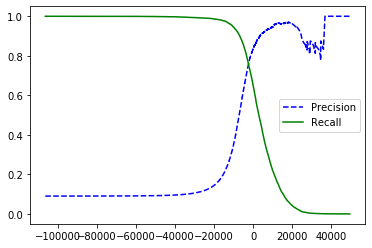

In [23]:
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.legend(frameon=True)
plot_precision_recall_threshold(precisions, recalls, thresholds)

Choose the threshold where precision is over 90%

In [24]:
threshold_90_prec = thresholds[np.argmax(precisions>=0.9)]
threshold_90_prec

3370.0194991439557

In [25]:
y_train_pred90 = (y_scores >= threshold_90_prec)
y_train_pred90 

array([False, False, False, ...,  True, False, False])

In [26]:
precision_score(y_train_5, y_train_pred90)

0.9000345901072293

In [27]:
recall_score(y_train_5, y_train_pred90)

0.4799852425751706

<a id='part3'></a>
### The ROC Curve
The receiver operating characteristic curve is similair to precision/recall curve where we plot the true positive rate (recall) against false positive rate (1-true negative rate or 1-specificity)

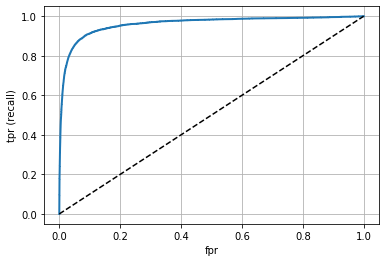

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('fpr')
    plt.ylabel('tpr (recall)')
    plt.grid()
    
plot_roc_curve(fpr, tpr)

AUC: Area under the curve, a perfect classifier would have roc auc equal to 1

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [31]:
y_scores_forest = y_prob_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

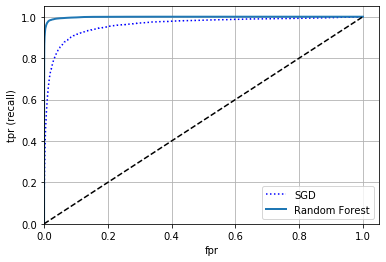

In [38]:
plt.plot(fpr, tpr, 'b:',label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.legend(loc='lower right')
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [52]:
precision_score(y_train_5, y_scores_forest.round())

0.9905083315756169

In [53]:
recall_score(y_train_5, y_scores_forest.round())

0.8662608374838591

<a id='part4'></a>
### Multiclass classification

strategies:
- One Vs All: Training a binary classifier for each class (like we did above with 5) and when we want to classify an image we get the decision score from each classifier and select the class with highest output
- One Vs One: Training a binary classifier for each pair of classes (for N classes we train $$\frac{N*(N-1)}{2}$$ classifiers ) and when we want to classify an image we run through all classifiers and see which class wins the most duels.

sklearn detects when we use a binary classifier for a multiclass classification and it automatically runs OvA (except for SVM's, OvO)

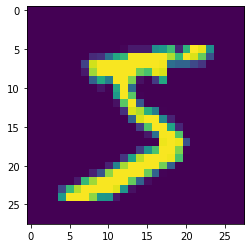

In [63]:
plt.imshow(X[0].reshape(28,28))

In [54]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[0]])

array([3], dtype=uint8)

In [61]:
some_digit_scores = sgd_clf.decision_function([X[0]])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [62]:
np.argmax(some_digit_scores)

3

In [65]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### Using OneVsOne classifier in sklearn

In [67]:
%%time
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X[0]])

CPU times: user 36.7 s, sys: 248 ms, total: 37 s
Wall time: 37 s


array([5], dtype=uint8)

In [70]:
len(ovo_clf.estimators_)

45

Training a random forest on whole train set

In [72]:
%%time
forest_clf.fit(X_train, y_train)
forest_clf.predict([X[0]])

CPU times: user 30.1 s, sys: 87.9 ms, total: 30.2 s
Wall time: 30.3 s


array([5], dtype=uint8)

In [76]:
#call predict proba to see each class' probability aka score for random forests
forest_clf.predict_proba([X[0]])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

#### Evaluation without scaling inputs

In [77]:
%%time
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

CPU times: user 3min 22s, sys: 1.03 s, total: 3min 23s
Wall time: 3min 21s


array([0.87365, 0.85835, 0.8689 ])

#### Evaluation with scaling inputs

In [82]:
%%time
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

CPU times: user 9min, sys: 1.07 s, total: 9min 1s
Wall time: 9min


array([0.8983, 0.891 , 0.9018])

<a id='part5'></a>
### Error Analysis

In [83]:
%%time
import seaborn as sns
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

CPU times: user 8min 59s, sys: 1.27 s, total: 9min
Wall time: 8min 58s


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

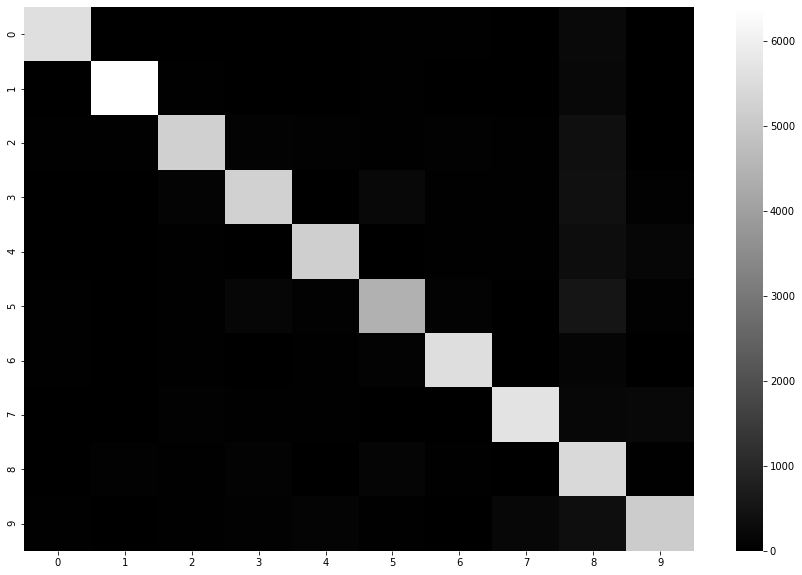

In [87]:
plt.figure(figsize=(15,10))
sns.heatmap(data=conf_mx, cmap=plt.cm.gray)
plt.show()

Plot the errors of each class individually

In [89]:
#divide each value in the conf_mx by the number of corresponding images
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

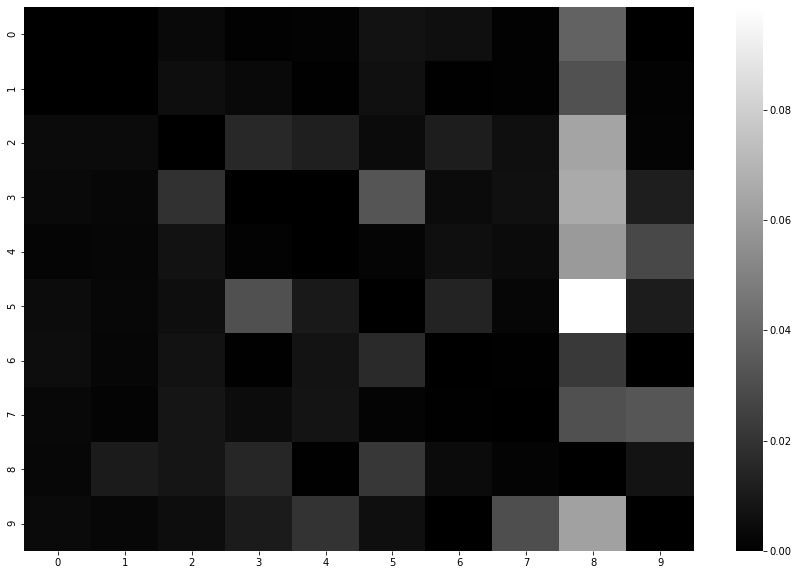

In [91]:
#fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx,0)
plt.figure(figsize=(15,10))
sns.heatmap(data=norm_conf_mx, cmap=plt.cm.gray)
plt.show()

The column for class 8 is bright meaning that for some classes we get confused by the class 8. However, for the class 8 (row) it is doing well, in general the image 8 gets properly classified.

<a id='part6'></a>
## Multilabel Classification

Output multiple classes for each instance

Create a y_multilabel array containing two target labels, y_train_large if the digit is grater than 7 and y_train_odd if it is odd

In [92]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [93]:
knn_clf.predict([X[0]])

array([[False,  True]])

The digit 5 is indeed not large ( False ) and odd ( True ).

In [94]:
#evaluate using f score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

KeyboardInterrupt: 

In [ ]:
# setting the hyperparameter average to 'macro' assumes that all labels are equally important
# setting the hyperparameter average to 'weighted' solves this problem
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

<a id='part7'></a>
## Multioutput Classification
each output label can be a multiclass for example, predicting whether the image is of a dog or a cat where the dog and cat labels have subclasses of the dog or cat's actual type
- image --> dog --> Pitbull 
- image --> cat --> ciamois

### MNIST images digit segmentation

Create a noisy dataset out of the original mnist and set out target labels to the actual numbers.

objective: highlight the number of a noisy image

In [95]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

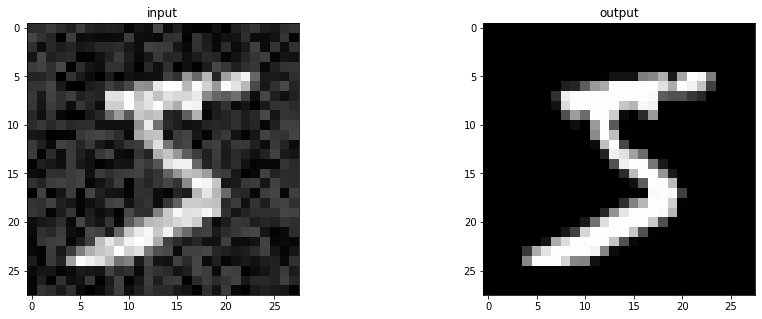

In [98]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(X_train_mod[0].reshape(28,28), cmap=plt.cm.gray)
plt.title('input')
plt.subplot(122)
plt.imshow(y_train_mod[0].reshape(28,28), cmap=plt.cm.gray)
plt.title('output')
plt.show()

CPU times: user 9.7 s, sys: 132 ms, total: 9.83 s
Wall time: 9.83 s


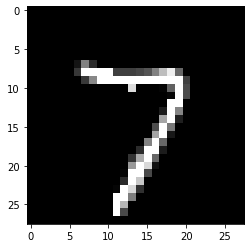

In [102]:
%%time
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plt.imshow(clean_digit.reshape(28,28), cmap=plt.cm.gray)

<a id='part8'></a>
# Final model

## 1.  build a classifier for MNIST dataset that achieves 97% accuracy

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import time


forest_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
logistic_clf = LogisticRegression(random_state=42)

models = [forest_clf,svc_clf,gb_clf,logistic_clf]

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(test_size=0.3)
sss.get_n_splits(X,y)

10

In [6]:
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(49000, 784) (21000, 784) (49000,) (21000,)


### KNN classifier

In [10]:
%%time
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_clf.fit(X_train,y_train)

CPU times: user 9.15 s, sys: 28.1 ms, total: 9.18 s
Wall time: 9.16 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [11]:
%%time
preds = knn_clf.predict(X_test)
score = accuracy_score(preds, y_test)
score

CPU times: user 10min 54s, sys: 59.9 ms, total: 10min 54s
Wall time: 10min 55s


0.9714

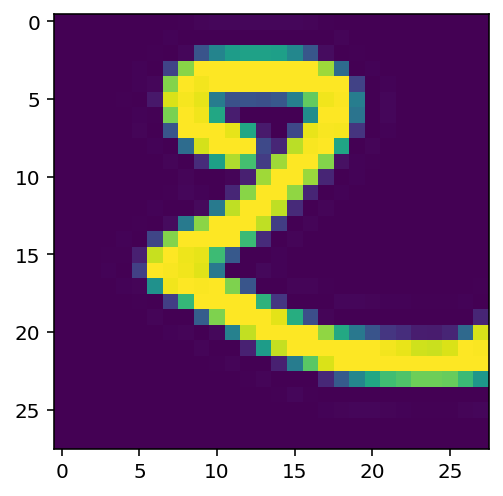

In [43]:
from skimage import io
from skimage.transform import resize
from PIL import Image
import numpy as np


img = Image.open('window2840.png').convert('L')
img = img.resize((28, 28), Image.ANTIALIAS)
img = np.asarray(img)
np.set_printoptions(suppress=True)
plt.imshow(img)
plt.show()

In [45]:
print(model.predict([img.reshape(-1)]).argmax())

2


Save model for inference

In [19]:
from sklearn.externals import joblib

#joblib.dump(model, 'log_reg.pkl')
joblib.dump(knn_clf, 'knn.pkl')

/home/zowlex/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['knn.pkl']

Load model

model = joblib.load('log_reg.pkl')
model

In [ ]:
print('Testing diffrent algorithms with default hyperpaprameters and is score based on first 1000 imgs:\n')
for model in models:
    toc = time.time()
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    score = accuracy_score(preds,y_test)
    tic = time.time()
    print('model: {} score: {:.2f} time: {}'.format(type(model).__name__,score, tic-toc))

<a id='data_aug'></a>
## 2.Data Augmentation

In [3]:
#create 4 shifted copies in each direction of img
def shift_img(img, value=2):
    if img.shape == (784,):
        img = img.reshape(28,28)
        
    shift_left = shift(img, [0,-value], cval=0).reshape(-1)
    shift_right = shift(img, [0,value], cval=0).reshape(-1)
    shift_up = shift(img, [-value,0], cval=0).reshape(-1)
    shift_down = shift(img, [value,0], cval=0).reshape(-1)
    return shift_left, shift_right, shift_up, shift_down

In [4]:
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

#shift the image by 5 pixels down and 5 pixels to the right and fill the outside boundaries with 0
# N.B: shift : (-) --> up, left
#Axes [ (-)up/down, (-)left/right]
# shifted_img = shift(img, [5,5], cval=0)
def plot_shifted_img(img):
    left_shift, right_shift, up_shift, down_shift = shift_img(img)

    plt.figure(figsize=(20,10))

    plt.subplot(151)
    plt.imshow(img.reshape(28,28), cmap=plt.cm.gray)
    plt.title('normal')

    plt.subplot(152)
    plt.imshow(left_shift.reshape(28,28), cmap=plt.cm.gray)
    plt.title('left shifted')

    plt.subplot(153)
    plt.imshow(right_shift.reshape(28,28), cmap=plt.cm.gray)
    plt.title('right shifted')

    plt.subplot(154)
    plt.imshow(up_shift.reshape(28,28), cmap=plt.cm.gray)
    plt.title('up shifted')

    plt.subplot(155)
    plt.imshow(down_shift.reshape(28,28), cmap=plt.cm.gray)
    plt.title('down shifted')

    plt.show()

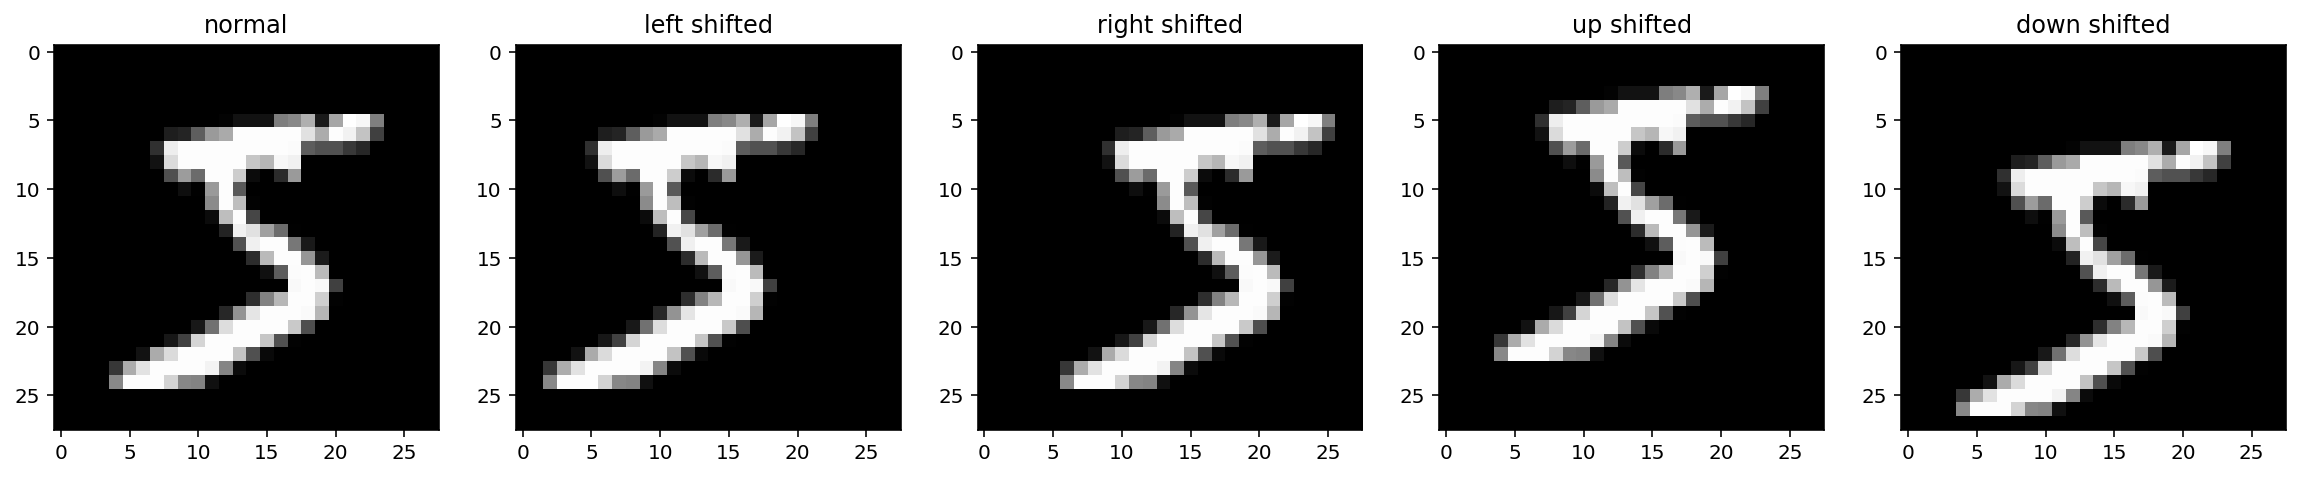

In [6]:
plot_shifted_img(X[0])

Add shifted copies to dataset

In [5]:
from tqdm import tqdm

def data_augmentation(train_data, target, shift_amount=2):
    """
    This function make 4 shifted copies for each image by shift_amount in pixels:
    
    Image --------> Image, Image_shifted_left, Image_shifted_right, Image_shifted_up, Image_shifted_down                 
    
    """
    
    X_augmented = np.zeros((train_data.shape[0]*5,784))
    y_augmented = np.zeros((train_data.shape[0]*5))

    for i, (img, label) in tqdm(enumerate(zip(train_data,target))):
        #print(f'processing img {i}')
        #For each image in X_copy we generate 4 shifted copies and assign them to X_augmented
        left_shift, right_shift, up_shift, down_shift = shift_img(img, shift_amount)

        #j is made to preserve original images indexes
        j = i*5
        X_augmented[j] = img
        X_augmented[j+1] = left_shift
        X_augmented[j+2] = right_shift
        X_augmented[j+3] = up_shift
        X_augmented[j+4] = down_shift

        #assign labels for new images
        for k in range(5):
            y_augmented[j+k] = label
            
    return X_augmented, y_augmented    

In [6]:
X_augmented, y_augmented = data_augmentation(X,y)

70000it [00:27, 2561.50it/s]


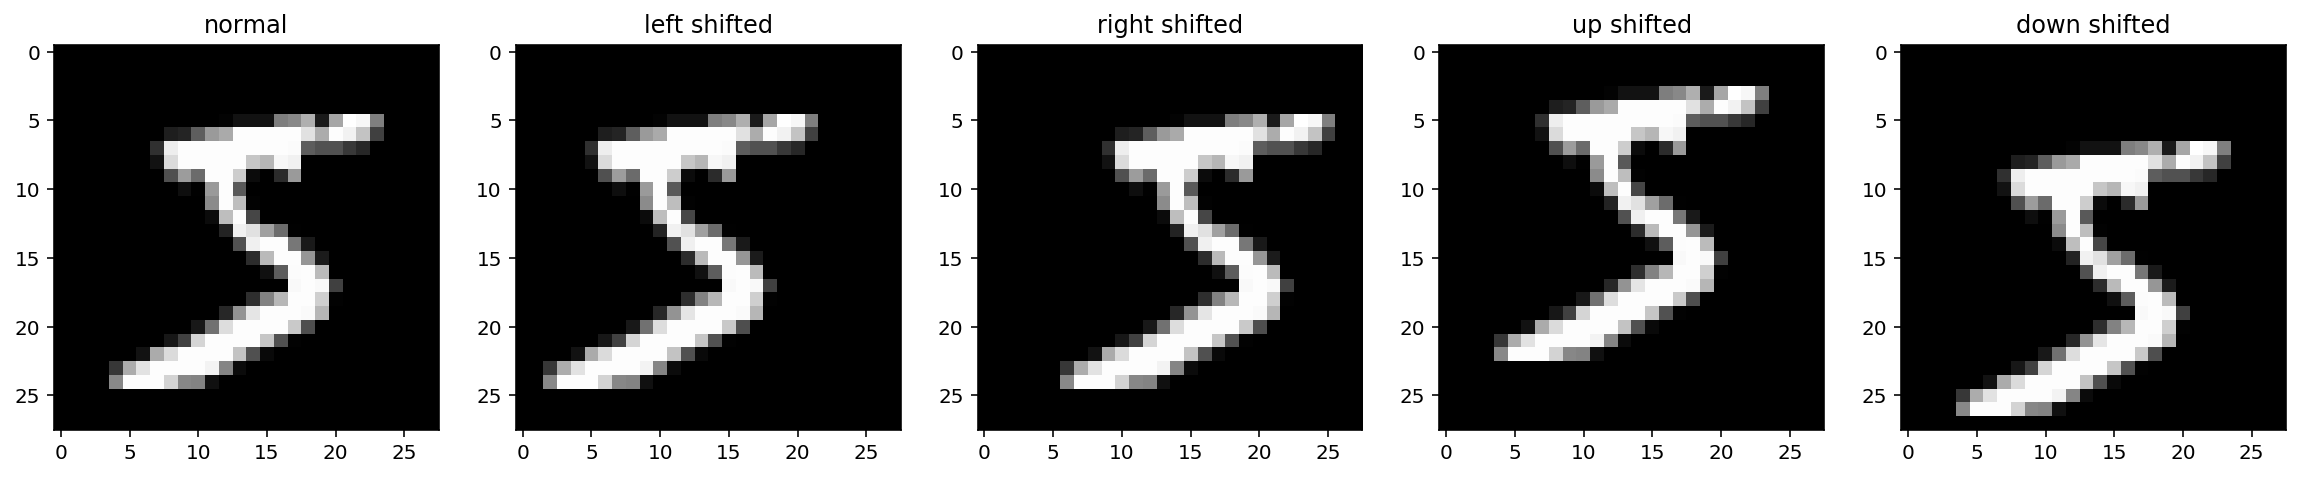

In [7]:
plot_shifted_img(X_augmented[0])

## Retrain model on augmented data for 97+ Accuracy

In [14]:
from sklearn.model_selection import cross_validate

knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')

In [15]:
cross_val = cross_validate(knn_clf, X, y,scoring='accuracy' ,n_jobs=-1,verbose=5 ,cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 22.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 22.9min finished


In [17]:
cross_val['test_score'].mean()

0.9703285516208252

In [21]:
cross_val_augmented = cross_validate(knn_clf, X_augmented, y_augmented,scoring='accuracy' ,n_jobs=-1,verbose=3 ,cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

### LightGBM model

In [16]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

training lgbm

In [23]:
X_train, X_valid, y_train, y_valid= train_test_split(X_augmented,y_augmented,shuffle=True)

In [34]:
param = {
   "objective" : "multiclass",
    "num_class": 10,
    "metric" : "softmax",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : 10,
    "verbosity" : 40,
}

In [35]:
#dataset
trn_data = lgb.Dataset(X_train,y_train)
val_data = lgb.Dataset(X_valid,y_valid)

#Training
model = lgb.train(param, trn_data, 1000000, valid_sets = [val_data], verbose_eval=500, early_stopping_rounds = 3000)

Training until validation scores don't improve for 3000 rounds
[500]	valid_0's multi_logloss: 0.582522
[1000]	valid_0's multi_logloss: 0.34977
[1500]	valid_0's multi_logloss: 0.259589
[2000]	valid_0's multi_logloss: 0.21211
[2500]	valid_0's multi_logloss: 0.183017
[3000]	valid_0's multi_logloss: 0.163407
[3500]	valid_0's multi_logloss: 0.149661
[4000]	valid_0's multi_logloss: 0.138932
[4500]	valid_0's multi_logloss: 0.130438
[5000]	valid_0's multi_logloss: 0.123325
[5500]	valid_0's multi_logloss: 0.117418
[6000]	valid_0's multi_logloss: 0.112326
[6500]	valid_0's multi_logloss: 0.107907
[7000]	valid_0's multi_logloss: 0.104008
[7500]	valid_0's multi_logloss: 0.100549
[8000]	valid_0's multi_logloss: 0.0974226
[8500]	valid_0's multi_logloss: 0.0946347
[9000]	valid_0's multi_logloss: 0.0920481
[9500]	valid_0's multi_logloss: 0.0897641
[10000]	valid_0's multi_logloss: 0.087616
[10500]	valid_0's multi_logloss: 0.0856952
[11000]	valid_0's multi_logloss: 0.0839437
[11500]	valid_0's multi_loglo

In [53]:
preds = model.predict(X_valid).argmax(axis=1)
acc_score = accuracy_score(preds,y_valid)

In [54]:
acc_score

0.9804571428571428

In [48]:
from sklearn.externals import joblib

joblib.dump(model, 'lgb.pkl')

['lgb.pkl']